In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

In [2]:
def make_hello(N = 1000, rseed = 42):
    #make a plot with 'HELLO' and save as .png
    fig, ax = plt.subplots(figsize = (4, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1)
    ax.axis('off')
    
    ax.text(0.5, 0.4, 'HELLO', va = 'center', ha = 'center', weight = 'bold', size = 85)
    fig.savefig('data\hello.png')
    plt.close(fig)
    
    from matplotlib.image import imread
    data = imread('data\hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

In [3]:
X = make_hello(1000)

In [4]:
def random_projection(X, dimension = 3, rseed = 42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

In [5]:
X3 = random_projection(X, 3)

In [6]:
print(X.shape)
print(X3.shape)

(1000, 2)
(1000, 3)


In [7]:
colorize = dict(c =  X[:, 0], cmap = plt.cm.get_cmap('rainbow', 5))

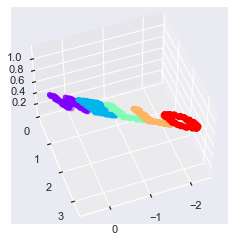

In [8]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection = '3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)
ax.view_init(azim = 70, elev = 50)

In [9]:
from sklearn.manifold import MDS

In [10]:
model = MDS(n_components = 2, random_state = 1)
out3 = model.fit_transform(X3)

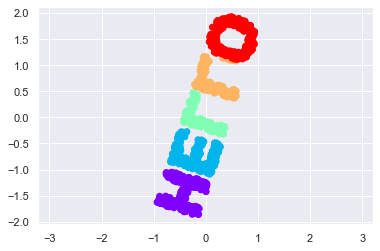

In [11]:
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

In [12]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

In [13]:
XS = make_hello_s_curve(X)

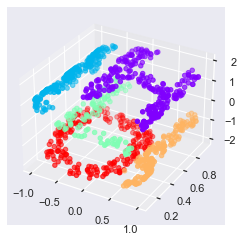

In [14]:
ax = plt.axes(projection = '3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);

In [15]:
model = MDS(n_components = 2, random_state = 2)
outS = model.fit_transform(XS)

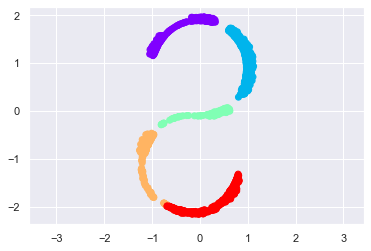

In [16]:
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

In [17]:
from sklearn.manifold import LocallyLinearEmbedding

model = LocallyLinearEmbedding(n_neighbors = 100, n_components = 2, method = 'modified', eigen_solver = 'dense')
out = model.fit_transform(XS)

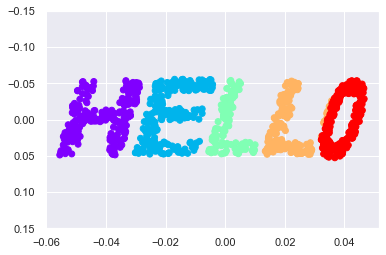

In [18]:
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
plt.ylim(0.15, -0.15);

In [19]:
from sklearn.manifold import Isomap

model = Isomap(n_neighbors = 100, n_components = 2, eigen_solver = 'dense')
out = model.fit_transform(XS)

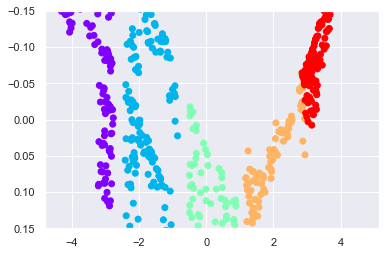

In [20]:
fig, ax = plt.subplots()

ax.scatter(out[:, 0], out[:, 1], **colorize)
plt.ylim(0.15, -0.15);

In [21]:
from sklearn.manifold import TSNE

model = TSNE(n_components = 2)
out = model.fit_transform(XS)

C:\Users\U\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\U\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


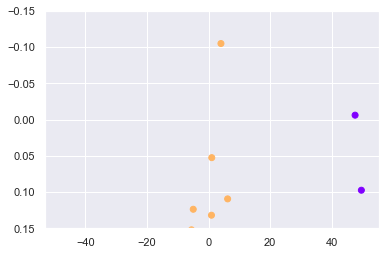

In [22]:
fig, ax = plt.subplots()

ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set(ylim = (0.15, -0.15));

In [23]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person = 30)
faces.data.shape

(2370, 2914)

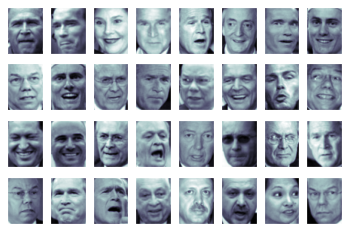

In [24]:
fig, ax = plt.subplots(4, 8, subplot_kw = dict(xticks = [], yticks = []))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap = 'bone');

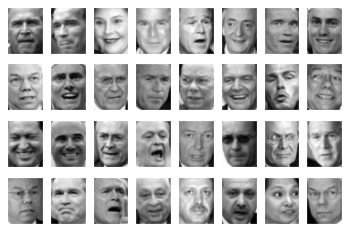

In [25]:
fig, ax = plt.subplots(4, 8, subplot_kw = dict(xticks = [], yticks = []))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap = 'gray');

In [26]:
from sklearn.decomposition import PCA

model = PCA(n_components = 100, svd_solver = 'randomized').fit(faces.data)

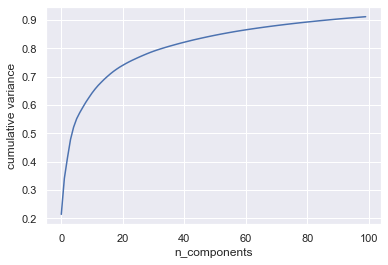

In [27]:
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n_components')
plt.ylabel('cumulative variance');

In [28]:
model = Isomap(n_components = 2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [29]:
from matplotlib import offsetbox

def plot_components(data, model, images = None, ax = None, thumb_frac = 0.05, cmap = 'gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                continue   #don't show points that are to close
                
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap = cmap), proj[i])
            ax.add_artist(imagebox)

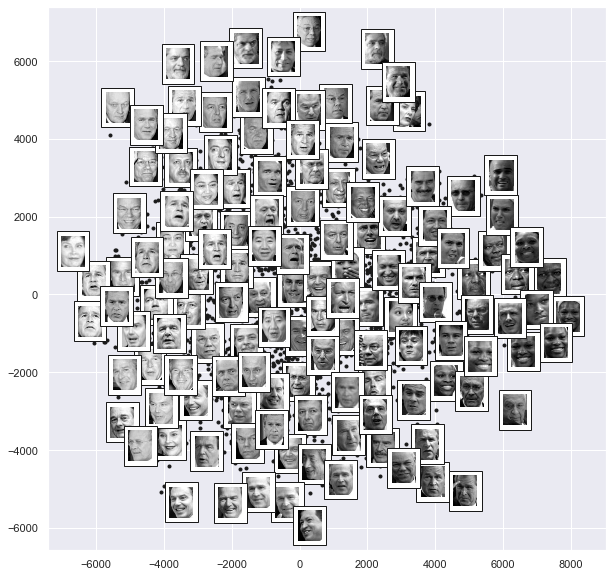

In [30]:
fig, ax = plt.subplots(figsize = (10, 10))
plot_components(faces.data, model = Isomap(n_components = 2), images = faces.images[:, ::2, ::2])

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

mnist.data.shape

fig, ax = plt.subplots(6, 8, subplot_kw = dict(xticks = [], yticks = []))

for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[i].reshape(28, 28), cmap = 'gray_r');

In [31]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

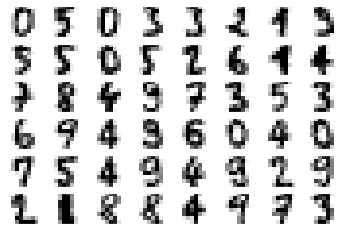

In [32]:
fig, ax = plt.subplots(6, 8, subplot_kw = dict(xticks = [], yticks = []))

for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[15 * i], cmap = 'gray_r')

In [33]:
model = Isomap(n_components = 2)
proj = model.fit_transform(digits.data)

C:\Users\U\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\U\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


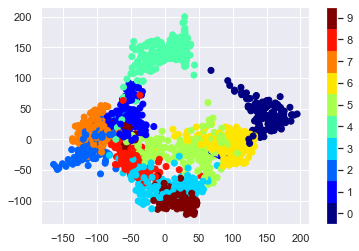

In [34]:
plt.scatter(proj[:, 0], proj[:, 1], c = digits.target, cmap = plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks = range(10))
plt.clim(-0.5, 9.5);

C:\Users\U\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\U\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


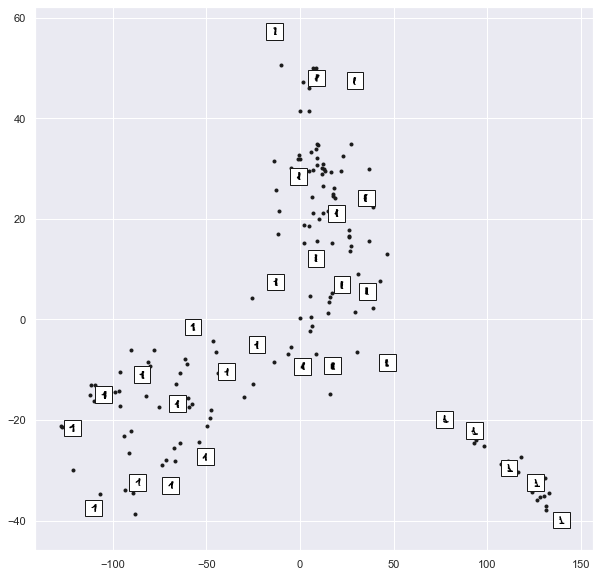

In [35]:
data1 = digits.data[digits.target == 1]
data1_images = digits.images[digits.target == 1]

model = Isomap(n_neighbors = 5, n_components = 2, eigen_solver = 'dense')

fig, ax = plt.subplots(figsize = (10, 10))
plot_components(data1, model, images = data1_images, ax = ax, cmap = 'gray_r')

In [36]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples = 300, centers = 4, cluster_std = 0.60, random_state = 0)

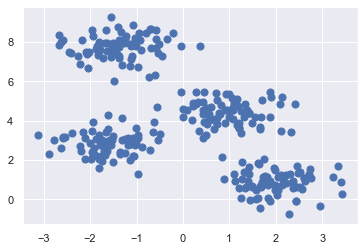

In [37]:
plt.scatter(X[:, 0], X[:, 1], s = 50);

In [38]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [39]:
y_kmeans = kmeans.predict(X)

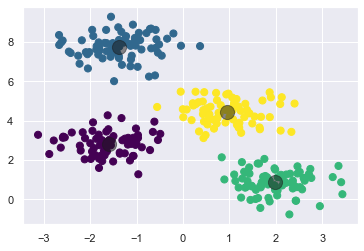

In [40]:
plt.scatter(X[:, 0], X[:, 1], c = y_kmeans, s = 50, cmap = 'viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'k', s = 200, alpha = 0.5);

In [41]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed = 2):
    #Randomly choose clusters
    
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        #2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        #2b. Find new centers from mean of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        #2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
        
    return centers, labels

In [42]:
centers, labels = find_clusters(X, 4)

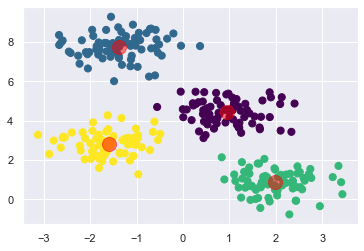

In [43]:
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 50, cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 200, alpha = 0.5);

In [44]:
centers, labels = find_clusters(X, 4, rseed = 0)

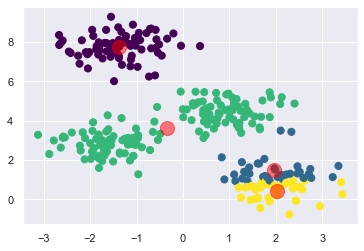

In [45]:
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 50, cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 200, alpha = 0.5);

In [46]:
labels = KMeans(6, random_state = 0).fit_predict(X)

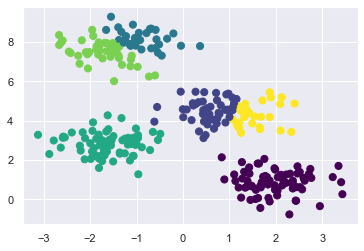

In [47]:
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 50, cmap = 'viridis');

In [48]:
from sklearn.datasets import make_moons

X, y = make_moons(200, noise = .05, random_state = 0)

In [49]:
labels = KMeans(2, random_state = 0).fit_predict(X)

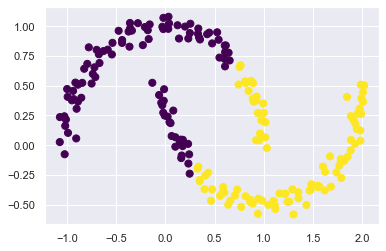

In [50]:
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 50, cmap = 'viridis');

In [51]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', assign_labels = 'kmeans')

labels = model.fit_predict(X)

C:\Users\U\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


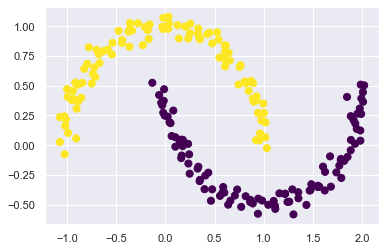

In [52]:
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 50, cmap = 'viridis');

In [53]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [54]:
kmeans = KMeans(n_clusters = 10, random_state = 0)
clusters = kmeans.fit_predict(digits.data)

In [55]:
kmeans.cluster_centers_.shape

(10, 64)

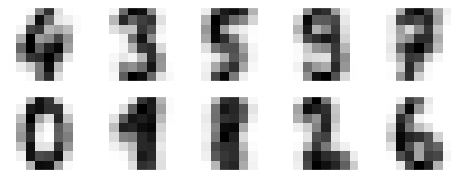

In [56]:
centers = kmeans.cluster_centers_.reshape(10, 8, 8)

fig, ax = plt.subplots(2, 5, figsize = (8, 3))
for axi, center in zip(ax.flat, centers):
    axi.set(xticks = [], yticks = [])
    axi.imshow(center, interpolation = 'nearest', cmap = 'binary')

In [67]:
from scipy.stats import mode

labels = np.zeros_like(clusters)

for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [69]:
from sklearn.metrics import accuracy_score

accuracy_score(digits.target, clusters)

0.015581524763494713

In [68]:
from sklearn.metrics import accuracy_score

accuracy_score(digits.target, labels)

0.7935447968836951

In [70]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(digits.target, labels)

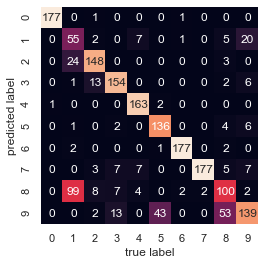

In [74]:
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False,
           xticklabels = digits.target_names, yticklabels = digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [75]:
from sklearn.manifold import TSNE

#project the data: this step will take seveal seconds
tsne = TSNE(n_components = 2, init = 'pca', random_state = 0)
digits_proj = tsne.fit_transform(digits.data)

C:\Users\U\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\U\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [76]:
#Compute the clusters
kmeans = KMeans(n_clusters = 10, random_state = 0)
clusters = kmeans.fit_predict(digits_proj)

In [77]:
#Permute the labels
labels = np.zeros_like(clusters)

for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [78]:
accuracy_score(digits.target, labels)

0.9432387312186978